# Определение стоимости автомобилей

# Описание проекта:

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

In [1]:
# ! pip install sklearn

In [2]:
# ! pip install catboost

In [3]:
# ! pip install lightgbm

In [73]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import time

In [35]:
df = pd.read_csv('/datasets/autos.csv')
df_full = df.copy()

In [36]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проведем первичный осмотр данных и выявим их проблемы.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [38]:
# Проверим дубликаты 
df.duplicated().sum()

4

In [39]:
df = df.drop_duplicates()

In [40]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [41]:
# посмотрим на пропуски 
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
NotRepaired          0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

**Вывод:**
 - В данных присутсвуют лишнии колонки 
 - Были удалены дубликаты
 - Необходима обработка пропусков 

### Предобработка данных

Удалим лишнии колонки

In [42]:
df= df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns') 

In [43]:
# Переведем колонки в нижний регистр
df.columns = df.columns.str.lower()

<AxesSubplot:>

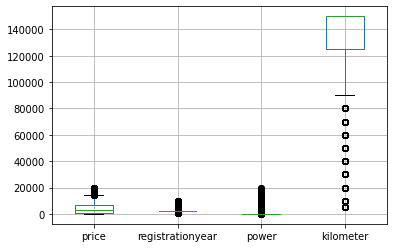

In [44]:
df.boxplot()

Становитсья видно что в данных много выбросов, не обходимо рассмотреть по подробнее некоторые важные колонки.

<AxesSubplot:>

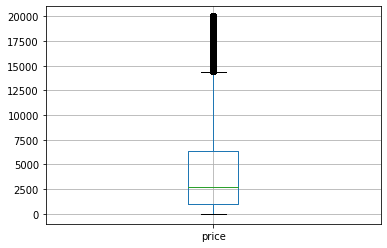

In [45]:
df.boxplot('price')

Цена на автомобиль не может быть нулевая, очистим данные от них.

In [46]:
df = df.query('price > 500')

Посмотрим на колонку `power`

<AxesSubplot:>

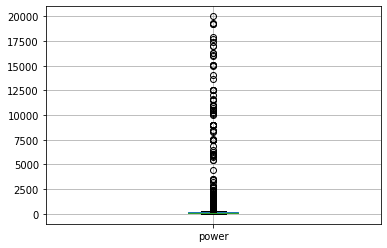

In [47]:
df.boxplot('power')

В данных очень сильные выбросы, проанализируем представленные бренды автомобилей и постараемся выявить границу реальных данных для мошности.

<AxesSubplot:>

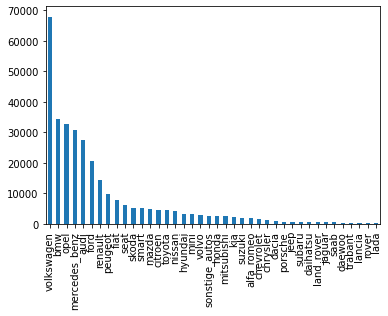

In [48]:
ax = df['brand'].value_counts()
ax.plot(kind='bar')

В брендах отсутствуют громкие названия гиперкаров по типу Buggati имеющие более 1000л\с а значит что значения мошности сильно завышены.

Мощность серийных автомобилей очень редко превышает 600л\с, возьмем эту цифру за верхнюю границу, ну и машин с 0 мошностью не бывает. 

In [49]:
df = df.query('power > 50 and power < 600')

<AxesSubplot:>

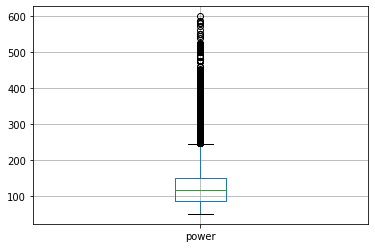

In [50]:
df.boxplot('power')

Взгляним на признак `registrationyear`

<AxesSubplot:>

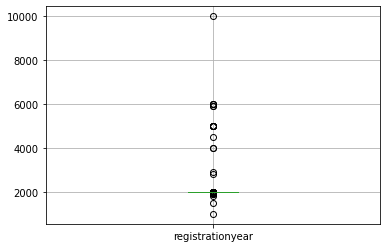

In [51]:
df.boxplot('registrationyear')

Так же можем наблюдать не верные данные. 10000 год нас только ждет )

In [52]:
df = df.query('registrationyear > 1980 and registrationyear < 2016')

<AxesSubplot:>

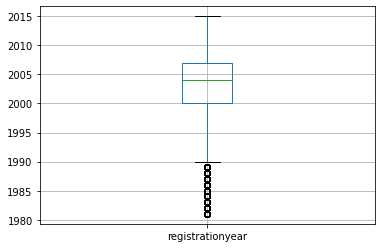

In [53]:
# Посмотрим еще раз.
df.boxplot('registrationyear')

Заполним пропуски в колонке `notrepaired` нулем 0 так как скорее всего при заполнении данных этот пункт пропускался из-за отсутсвия ремонта.

In [54]:
df['notrepaired'] = df['notrepaired'].fillna(0)

In [55]:
# Взгляним еще раз на пропуски.
df.isna().mean()

price               0.000000
vehicletype         0.012225
registrationyear    0.000000
gearbox             0.013931
power               0.000000
model               0.030654
kilometer           0.000000
fueltype            0.037440
brand               0.000000
notrepaired         0.000000
dtype: float64

Пропусков ~ 5% считаю это не значительным числом и просто дропну оставшиеся пропуски.

In [56]:
df = df.dropna()

In [57]:
print('Из первоначальной базы данных понадобилась убрать {0:.1f}% данных'.format((len(df_full) - len(df)) / (len(df_full)/100)))

Из первоначальной базы данных понадобилась убрать 31.9% данных


**Вывод:**
- Удалили лишнии колонки в данных
- Поменяли регистр колонок
- Детально взглянули на колонки `registrationyear`, `  power`, `  price ` и убрали выбросы из них
- Заполнили пропуски в колонке `notrepaired` а остальные просто удалили

<AxesSubplot:>

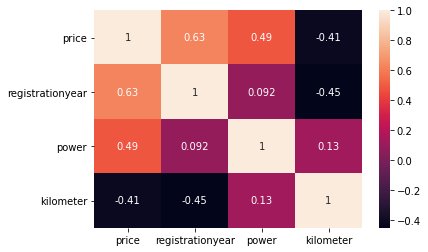

In [58]:
sns.heatmap(df.corr(),annot = True)

## Обучение и анализ моделей 

Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные. 

In [59]:
#приведем категориальные признаки в номинальные с помощью LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
columns_for_convert = list(df.select_dtypes(include='object').columns)
for column in columns_for_convert:
    label_encode.fit(df[column].astype('str'))
    df[column] = label_encode.transform(df[column].astype('str'))

In [61]:
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
2,9800,6,2004,0,163,116,125000,2,14,0
3,1500,5,2001,1,75,115,150000,6,37,1
4,3600,5,2008,1,69,100,90000,2,31,1
5,650,4,1995,1,102,11,150000,6,2,2
6,2200,1,2004,1,109,8,150000,6,25,1
...,...,...,...,...,...,...,...,...,...,...
354359,7900,4,2010,1,140,115,150000,2,37,1
354362,3200,4,2004,1,225,139,150000,6,30,2
354366,1199,1,2000,0,101,105,125000,6,32,1
354367,9200,0,1996,1,102,221,150000,2,37,1


In [62]:
#Стандартизируем признаки с помощью StandardScaler
scaler = StandardScaler()
numeric = ['registrationyear','power','kilometer']
scaler.fit(df[numeric])
df[numeric] = scaler.transform(df[numeric])

In [63]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [64]:
#тоже самое для линейной регрессии
features_lr = df_ohe.drop(['price'], axis = 1)
target_lr = df_ohe['price']

In [123]:
#Посмотрим сколько уникальных значений мы имеем в categorical признаках
categorical = ['brand','model','vehicletype','gearbox','fueltype']
numerical_features_names = df.select_dtypes(include=['int64'])
df[categorical].nunique()

brand           39
model          247
vehicletype      8
gearbox          2
fueltype         7
dtype: int64

In [143]:
#Приведем категориальные признаки к формату category
df[categorical] = df[categorical].astype('category')

In [144]:
df['notrepaired'] = df['notrepaired'].astype('int64')

In [145]:
df.columns = df.columns.astype('category')

In [147]:
#признаки для обучения моделей CBR и LGBM
features = df.drop(['price'], axis = 1)
target = df['price']

### Разобьем выборку на train и test

In [148]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target_lr, random_state=0)

In [149]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

Проверим разбиение, так как делили на 4 части, должно получитсья 25% в каждой переменной 

In [151]:
round((len(df) - len(features_train)) / (len(df)/100))

25

In [83]:
#напишем формулу для получения значения метрики RMSE
def rmse(target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

In [38]:
# object= StandardScaler()
# scale = object.fit_transform(features_train_lr)

Приступим к обучению и проанализируем время работы и качество моделей.

### CBR

In [89]:
#вызовем CatBoost с нашими параметрами
model_cbr = CatBoostRegressor(cat_features=categorical)

In [90]:
%%time
start = time.time()
model_cbr.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=200);
end = time.time()
catboost_time = end - start

Learning rate set to 0.115161
0:	learn: 4285.3904837	test: 4281.2531220	best: 4281.2531220 (0)	total: 242ms	remaining: 4m 1s
200:	learn: 1592.1256625	test: 1620.3124407	best: 1620.3124407 (200)	total: 34.3s	remaining: 2m 16s
400:	learn: 1529.0475963	test: 1570.9846332	best: 1570.9846332 (400)	total: 1m 6s	remaining: 1m 39s
600:	learn: 1495.9461287	test: 1549.9895329	best: 1549.9895329 (600)	total: 1m 40s	remaining: 1m 6s
800:	learn: 1471.1770769	test: 1535.6169939	best: 1535.6169939 (800)	total: 2m 14s	remaining: 33.5s
999:	learn: 1453.6662914	test: 1525.8760091	best: 1525.8760091 (999)	total: 2m 49s	remaining: 0us

bestTest = 1525.876009
bestIteration = 999

CPU times: user 2min 49s, sys: 959 ms, total: 2min 50s
Wall time: 2min 52s


In [91]:
#Посмотрим какую среднюю квадратичную абсолютную ошибку мы получили в предсказаниях.
start = time.time()
predictions = model_cbr.predict(features_test)
end = time.time()
catboost_time_predicting = end - start
print('RMSE=', rmse(predictions,target_test))
rmse_list = []
rmse_list.append(rmse(predictions,target_test))
time_list = []
predicting_time = []
time_list.append(catboost_time)
predicting_time.append(catboost_time_predicting)

RMSE= 1525.8760091237457


Можно отметить, что при увеличении iterations модель сначала дает намного бОльшую точность (в 2 раза), затем увеличение точности начинает снижаться, до тех пор, пока разница не становится совсем незначительной. Нужно помнить, что скорость обучения модели для нас важна так же, как и точность ее работы, поэтому не будем жертвовать скоростью и выберем оптимальный вариант с числом iterations 85.

При изменении параметра depth прослеживается такая же тенденция, поэтому оптимальной глубиной будет число 13.

In [95]:
model_cbr = CatBoostRegressor(loss_function='RMSE', 
                              iterations=85, 
                              learning_rate=0.2, 
                              thread_count=-1, 
                              random_state=1, 
                              max_depth=13, 
                              l2_leaf_reg=3.5,
                              cat_features=categorical
                              )

In [96]:
%%time
model_cbr.fit(features_train, target_train, cat_features=categorical)

0:	learn: 3960.4204313	total: 191ms	remaining: 16s
1:	learn: 3445.4229218	total: 367ms	remaining: 15.2s
2:	learn: 3043.9876507	total: 568ms	remaining: 15.5s
3:	learn: 2742.9113883	total: 746ms	remaining: 15.1s
4:	learn: 2514.9697097	total: 943ms	remaining: 15.1s
5:	learn: 2307.2282845	total: 1.15s	remaining: 15.2s
6:	learn: 2153.8037445	total: 1.34s	remaining: 14.9s
7:	learn: 2044.1711448	total: 1.52s	remaining: 14.6s
8:	learn: 1959.3172479	total: 1.7s	remaining: 14.3s
9:	learn: 1884.6800687	total: 1.88s	remaining: 14.1s
10:	learn: 1830.7891018	total: 2.08s	remaining: 14s
11:	learn: 1792.0225942	total: 2.3s	remaining: 14s
12:	learn: 1763.6908367	total: 2.5s	remaining: 13.9s
13:	learn: 1739.1340340	total: 2.68s	remaining: 13.6s
14:	learn: 1720.5258075	total: 2.86s	remaining: 13.3s
15:	learn: 1693.1966310	total: 3.04s	remaining: 13.1s
16:	learn: 1670.0672159	total: 3.23s	remaining: 12.9s
17:	learn: 1650.8990974	total: 3.43s	remaining: 12.8s
18:	learn: 1637.6359099	total: 3.66s	remaining:

In [98]:
start_time = time.time()
model_cbr = pd.Series(model_cbr.predict(features_test))

In [99]:
rmse(target_test, model_cbr)

1523.243472219664

### LinearRegression

In [100]:
lr_model = LinearRegression()

In [102]:
%%time
start = time.time()
lr_model.fit(features_train_lr, target_train_lr)
end = time.time()
linear_time = end - start

CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 36.8 ms


In [103]:
start = time.time()
predictions = lr_model.predict(features_train_lr)
end = time.time()
linear_time_predicting_ = end - start
print(rmse(predictions,target_train_lr))
rmse_list.append(rmse(predictions,target_train_lr))
time_list.append(linear_time)
predicting_time.append(linear_time_predicting_)

2737.472552001798


### LightGBM

In [152]:
gbm = lgb.LGBMRegressor(task='train', 
                        boosting_type='gbdt', 
                        objective='regression', 
                        metric='rmse', 
                        learning_rate=0.5, 
                        verbose=200, 
                        categorical_feature=categorical)

In [154]:
%%time
start = time.time()
gbm.fit(features_train, target_train, eval_set=[(features_test, target_test)], eval_metric='rmse', early_stopping_rounds=1000)
end = time.time()
lightgbm_time = end - start

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] categorical_feature is set=brand,model,vehicletype,gearbox,fueltype, categorical_column=0,2,4,6,7 will be ignored. Current value: categorical_feature=brand,model,vehicletype,gearbox,fueltype
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.801968
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.190453
[LightGBM] [Debug] init for col-wise cost 0.202423 seconds, init for row-wise cost 0.199147 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 180882, number of used features: 9


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 5425.699008
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[1]	valid_0's rmse: 3022.91
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[2]	valid_0's rmse: 2309.84
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[3]	valid_0's rmse: 2005.28
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[4]	valid_0's rmse: 1848.28
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[5]	valid_0's rmse: 1775.06
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[6]	valid_0's rmse: 1737.2
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[7]	valid_0's rmse: 1711.75
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[8]	valid_0's rmse: 1694.07
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[9]	valid_0's rmse: 1680.42
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[10]	valid_0's rmse: 1665.09
[LightGBM]

In [157]:
start = time.time()
predictions = gbm.predict(features_test,num_iteration=gbm.best_iteration_)
end = time.time()
lightgbm_predicting_time = end - start
print('RMSE = ', rmse(predictions, target_test))
rmse_list.append(rmse(predictions,target_test))
predicting_time.append(lightgbm_predicting_time)
time_list.append(lightgbm_time)

RMSE =  1531.6384709860274


## Вывод.

In [159]:
results_df = pd.DataFrame(data=[rmse_list,time_list, predicting_time], columns=['CatBoost','LightGBM','LinearRegression'], 
                          index=['RMSE','Learning Time','Predicting Time'])

In [162]:
results_df

,CatBoost,LightGBM,LinearRegression
RMSE,1525.876009,2737.472552,1531.638471
Learning Time,172.113188,0.036741,7.014367
Predicting Time,0.470150,0.007021,0.326337


Время предсказания любой модели значительно меньше, чем её обучение. 
Важно, чтобы время предсказания было как можно меньше - обучаем модель мы только один раз, но предсказывать она может до бесконечности.


Метрика RMSE лучше всего выглядит у модели CatBoost, но модель LinearRegression не сильно отстала по метрике RMSE от CatBoost но время обучение у нее в разы лучше, время предсказание так же несильно разниться у этих двух моделей, на мой взгляд CatBoost обладает гораздо большими перспективами в плане гиперпараметров и возможно CatBoost может показать лучший результат в метрике RMSE, я бы выбрал CatBoost